In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['font.family'] = 'Recipekorea'
pd.options.display.float_format = '{: .2f}'.format

In [3]:
# 데이터 로드
data = pd.read_csv('./데이터/일일별 전체 데이터.csv',parse_dates=True, encoding='utf-8', thousands=',')
data = data.drop(['품종'],axis=1)
data = data.set_index('일시')
data = data.sort_values('일시', ascending=True)
data.index = pd.to_datetime(data.index[:], format="%Y-%m-%d")
data

위판중량(kg)  평균 풍속(m/s)  평균기압(hPa)  평균 상대습도(%)  평균 기온(°C)  \
일시                                                                    
2013-01-01    5766.00        7.77    1020.87       56.33       7.27   
2013-01-02  253212.00        9.27    1027.30       57.67       5.17   
2013-01-03  119183.00        9.80    1033.87       59.67       0.03   
2013-01-04  128879.00        7.13    1029.20       54.33       1.37   
2013-01-05    3912.00        7.37    1024.60       53.67       3.30   
...               ...         ...        ...         ...        ...   
2023-03-31        NaN        5.06    1018.00       74.14      15.03   
2023-04-01        NaN        6.04    1015.69       83.12      15.66   
2023-04-02        NaN        8.80    1017.58       74.50      15.26   
2023-04-03        NaN       10.59    1021.02       77.75      14.88   
2023-04-04        NaN        8.93    1018.27       85.00      16.30   

            평균 수온(°C)  평균 최대 파고(m)  평균 유의 파고(m)  평균 파주기(sec)    WTI  
일시                                                                   
2013-01-01      14.53         2.27         1.50         6.27    NaN  
2013-01-02      14.83         2.37         1.53         5.40  93.12  
2013-01-03      14.40         2.40         1.53         5.37  92.92  
2013-01-04      14.13         1.87         1.17         6.03  93.09  
2013-01-05      14.10         1.47         0.93         5.50    NaN  
...               ...          ...          ...          ...    ...  
2023-03-31      14.77         1.56         0.93         5.64  75.67  
2023-04-01      15.29         1.81         1.04         5.45    NaN  
2023-04-02      15.05         3.04         1.85         6.03    NaN  
2023-04-03      15.18         3.74         2.38         6.61  80.42  
2023-04-04      15.22         2.89         1.79         5.91  80.71  

[3748 rows x 10 columns]

In [ ]:
TRAIN_SPLIT= 72
BATCH_SIZE = 36
BUFFER_SIZE = 10000
tf.random.set_seed(10)

In [ ]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정파일 위치: ', mpl.matplotlib_fname())

버전:  3.5.2
설치 위치:  c:\Users\admin\anaconda33\lib\site-packages\matplotlib\__init__.py
설정 위치:  C:\Users\admin\.matplotlib
캐시 위치:  C:\Users\admin\.matplotlib
설정파일 위치:  c:\Users\admin\anaconda33\lib\site-packages\matplotlib\mpl-data\matplotlibrc


array([<AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>,
       <AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>,
       <AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>,
       <AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>,
       <AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>,
       <AxesSubplot:xlabel='일시'>], dtype=object)

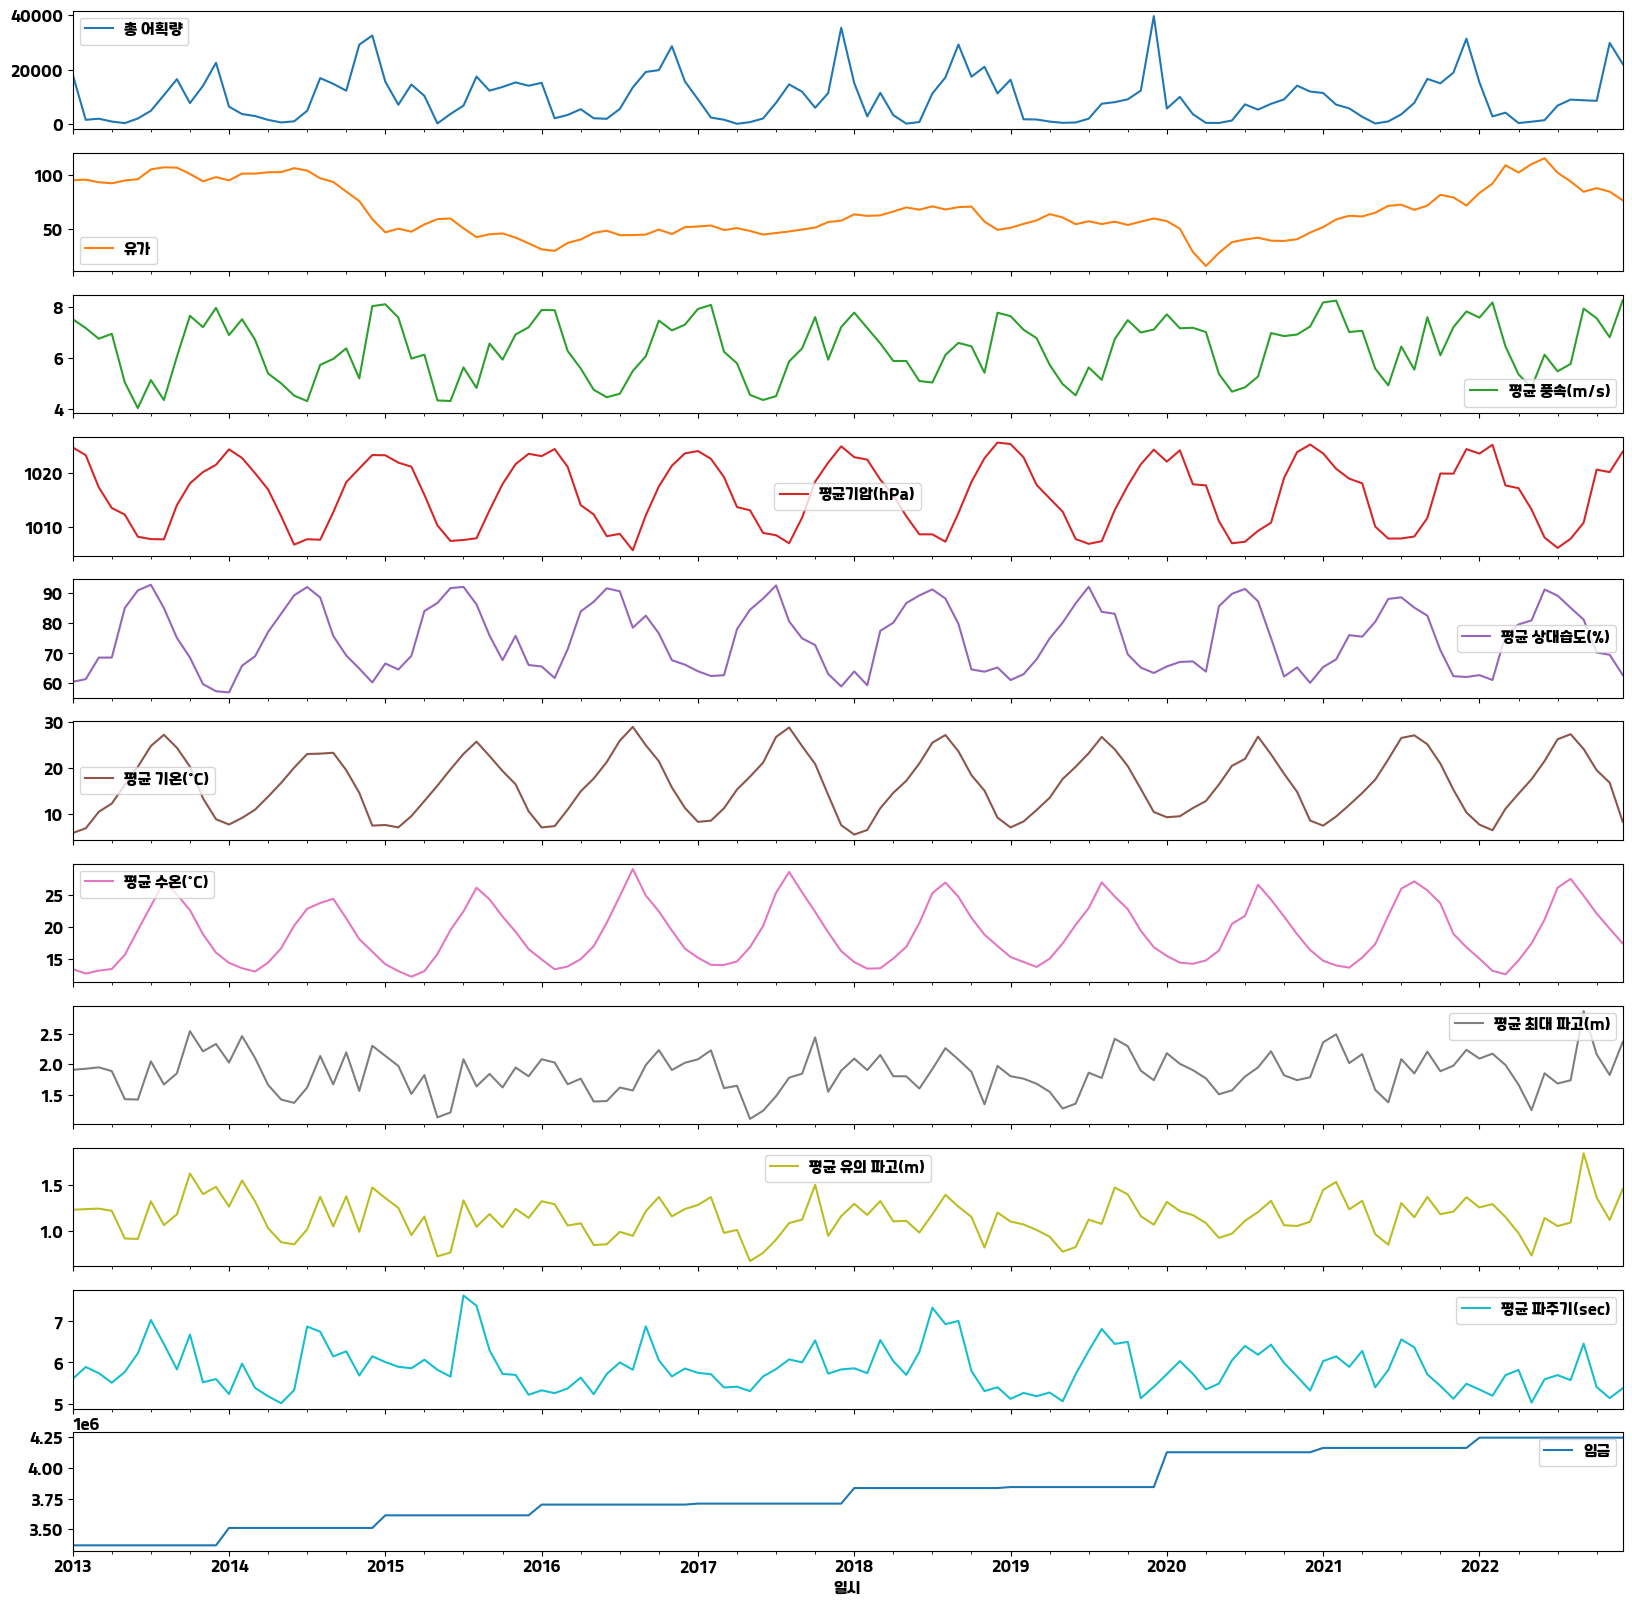

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)
features_considered = data.columns
features = data[:]
features.plot(subplots=True)

In [ ]:
features

총 어획량     유가  평균 풍속(m/s)  평균기압(hPa)  평균 상대습도(%)  평균 기온(°C)  \
일시                                                                          
2013-01-01  18170.14  94.76        7.53    1024.76       60.43       5.91   
2013-02-01   1671.15  95.31        7.18    1023.32       61.31       6.91   
2013-03-01   2075.89  92.94        6.76    1017.34       68.46      10.51   
2013-04-01   1042.23  92.02        6.96    1013.50       68.48      12.30   
2013-05-01    459.63  94.51        5.05    1012.28       84.96      16.36   
...              ...    ...         ...        ...         ...        ...   
2022-08-01   9063.25  93.67        5.77    1007.78       85.00      27.38   
2022-09-01   8813.18  84.26        7.94    1010.78       81.07      24.15   
2022-10-01   8612.48  87.55        7.56    1020.64       70.13      19.55   
2022-11-01  29771.41  84.37        6.82    1020.17       69.41      16.83   
2022-12-01  22098.02  76.44        8.26    1023.98       62.69       8.34   

            평균 수온(°C)  평균 최대 파고(m)  평균 유의 파고(m)  평균 파주기(sec)       임금  
일시                                                                     
2013-01-01      13.48         1.91         1.23         5.61  3371000  
2013-02-01      12.78         1.93         1.24         5.89  3371000  
2013-03-01      13.23         1.95         1.24         5.74  3371000  
2013-04-01      13.49         1.89         1.22         5.51  3371000  
2013-05-01      15.72         1.43         0.92         5.77  3371000  
...               ...          ...          ...          ...      ...  
2022-08-01      27.57         1.74         1.09         5.58  4243200  
2022-09-01      24.94         2.88         1.84         6.45  4243200  
2022-10-01      22.16         2.16         1.36         5.41  4243200  
2022-11-01      19.80         1.82         1.12         5.14  4243200  
2022-12-01      17.48         2.37         1.46         5.38  4243200  

[120 rows x 11 columns]

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[ 0.93603521  1.23528325  1.13004481 ...  0.41959485 -0.58527489
  -1.68865675]
 [-1.02039829  1.25929889  0.83312203 ...  0.45146685 -0.07179309
  -1.68865675]
 [-0.97240493  1.15581332  0.47617783 ...  0.47953933 -0.33929594
  -1.68865675]
 ...
 [-0.19730198  0.92046005  1.16084539 ...  1.0620433  -0.9396534
   4.1405507 ]
 [ 2.31170295  0.78160598  0.5266403  ... -0.11964485 -1.41726254
   4.1405507 ]
 [ 1.40179922  0.43534412  1.75810125 ...  1.51358162 -0.99282826
   4.1405507 ]]


In [ ]:
# df_std = pd.DataFrame(dataset,columns=data.columns,index=data.index)
# df_std.to_csv('정규화.csv',encoding='utf-8-sig')

In [ ]:
def create_time_steps(length):
    return list(range(-length,0))

In [ ]:
print(dataset)

[[ 0.93603521  1.23528325  1.13004481 ...  0.41959485 -0.58527489
  -1.68865675]
 [-1.02039829  1.25929889  0.83312203 ...  0.45146685 -0.07179309
  -1.68865675]
 [-0.97240493  1.15581332  0.47617783 ...  0.47953933 -0.33929594
  -1.68865675]
 ...
 [-0.19730198  0.92046005  1.16084539 ...  1.0620433  -0.9396534
   4.1405507 ]
 [ 2.31170295  0.78160598  0.5266403  ... -0.11964485 -1.41726254
   4.1405507 ]
 [ 1.40179922  0.43534412  1.75810125 ...  1.51358162 -0.99282826
   4.1405507 ]]


In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size # train(36) / valid(120)
  if end_index is None:
    end_index = len(dataset) # valid(120)
  
  
  for i in range(start_index, end_index): # train(36, 84) / valid(120, 120)
    indices = range(i-history_size, i, step) # train((0, 36) ~ (47, 83)) / 
    
    if indices == range((start_index+target_size-1), end_index-1):
      data.append(dataset[range((start_index+target_size-1), end_index)])
    else:
      data.append(dataset[indices])

    labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
def multivariate_val_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size # train(36) / valid(120)
  if end_index is None:
    end_index = len(dataset) # valid(120)
  
  
    indices = range(start_index-history_size, start_index, step) # train((0, 36) ~ (47, 83)) / 
    data.append(dataset[indices])
    labels.append(target[start_index:end_index])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 24
future_target = 12
STEP = 1

x_train, y_train = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT,past_history, future_target, STEP)

x_valid, y_valid = multivariate_val_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history,future_target, STEP)

In [ ]:
dataset[:,0]

array([ 0.93603521, -1.02039829, -0.97240493, -1.0949751 , -1.16405871,
       -0.96372784, -0.62855237,  0.04804334,  0.73976947, -0.29530141,
        0.45078595,  1.45064454, -0.45024304, -0.76998378, -0.85609878,
       -1.02299297, -1.13469181, -1.08559668, -0.62865904,  0.78775545,
        0.53993371,  0.24152534,  2.2368499 ,  2.63230684,  0.63192261,
       -0.36513146,  0.50937352,  0.0165283 , -1.17727778, -0.76762425,
       -0.40722367,  0.85328562,  0.24290574,  0.40405326,  0.60050874,
        0.45691095,  0.58360973, -0.95252342, -0.80949791, -0.56045073,
       -0.9521546 , -0.97593724, -0.55055878,  0.3859505 ,  1.05430381,
        1.13373567,  2.17082776,  0.6446403 , -0.12919733, -0.92486672,
       -1.01504934, -1.19276664, -1.12078486, -0.96232478, -0.27955168,
        0.51473256,  0.1977766 , -0.49805772,  0.13616195,  2.96801209,
        0.57119305, -0.87043049,  0.14808423, -0.81883863, -1.18559328,
       -1.11592504,  0.12107247,  0.8165393 ,  2.24192954,  0.84

In [ ]:
d= np.array(data)
d

array([[1.81701371e+04, 9.47600000e+01, 7.52741936e+00, ...,
        1.22956989e+00, 5.60537634e+00, 3.37100000e+06],
       [1.67114799e+03, 9.53100000e+01, 7.17951807e+00, ...,
        1.23614458e+00, 5.89156626e+00, 3.37100000e+06],
       [2.07588540e+03, 9.29400000e+01, 6.76129032e+00, ...,
        1.24193548e+00, 5.74247312e+00, 3.37100000e+06],
       ...,
       [8.61248130e+03, 8.75500000e+01, 7.56350806e+00, ...,
        1.36209677e+00, 5.40786290e+00, 4.24320000e+06],
       [2.97714142e+04, 8.43700000e+01, 6.82041667e+00, ...,
        1.11833333e+00, 5.14166667e+00, 4.24320000e+06],
       [2.20980168e+04, 7.64400000e+01, 8.26330645e+00, ...,
        1.45524194e+00, 5.37822581e+00, 4.24320000e+06]])

In [ ]:
len(x_train)


48

In [ ]:
print('Single window of past history : {}'.format(x_train[0].shape))
print('Target temp to predict : {}'.format(y_train[0].shape))

Single window of past history : (24, 11)
Target temp to predict : (12,)


In [ ]:
print(x_valid.dtype)
print(y_valid.dtype)
print(x_train.dtype)
print(y_train.dtype)

float64
float64
float64
float64


In [ ]:
print(x_train)

[[[ 0.93603521  1.23528325  1.13004481 ...  0.41959485 -0.58527489
   -1.68865675]
  [-1.02039829  1.25929889  0.83312203 ...  0.45146685 -0.07179309
   -1.68865675]
  [-0.97240493  1.15581332  0.47617783 ...  0.47953933 -0.33929594
   -1.68865675]
  ...
  [ 0.24152534  0.78291593  0.15568509 ...  1.13149118  0.60485859
   -0.74630608]
  [ 2.2368499   0.406962   -0.85059664 ... -0.74624536 -0.43811714
   -0.74630608]
  [ 2.63230684 -0.3135072   1.56734206 ...  1.59204931  0.39005776
   -0.74630608]]

 [[-1.02039829  1.25929889  0.83312203 ...  0.45146685 -0.07179309
   -1.68865675]
  [-0.97240493  1.15581332  0.47617783 ...  0.47953933 -0.33929594
   -1.68865675]
  [-1.0949751   1.1156417   0.64156478 ...  0.3605569  -0.75093847
   -1.68865675]
  ...
  [ 2.2368499   0.406962   -0.85059664 ... -0.74624536 -0.43811714
   -0.74630608]
  [ 2.63230684 -0.3135072   1.56734206 ...  1.59204931  0.39005776
   -0.74630608]
  [ 0.63192261 -0.84054133  1.62871992 ...  1.03615659  0.1429636
   -0.0

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

valid_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_data = valid_data.batch(BATCH_SIZE).repeat()

In [ ]:
for x,y in train_data.take(1):
    print(len(y[0]))

12


In [ ]:
def mplot(history, true_future, prediction, future_dates, future_predictions):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:,0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future),'b', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),'r', label='Predicted Future')
        plt.plot(future_dates, future_predictions, label='future prediction', linestyle='--', marker='o')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
for x,y in train_data.take(1):
    print(x[0].shape)
    print(y[0].shape)
    print(np.array([0]))

(24, 11)
(12,)
[0]


c:\Users\admin\anaconda33\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


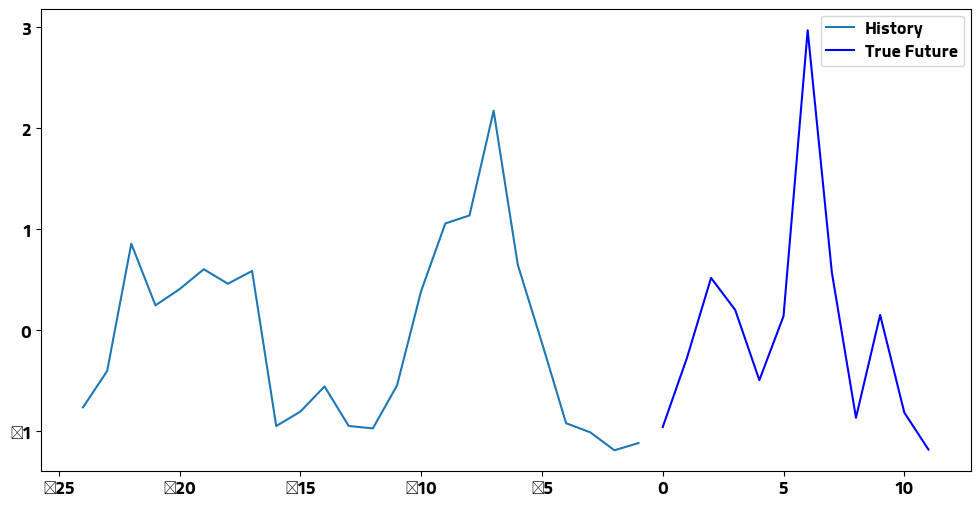

In [ ]:
for x,y in train_data.take(1):
    mplot(x[0], y[0], np.array([0]),np.array([0]),np.array([0]))

In [ ]:
input_shape=x_train.shape[-2:]
input_shape

(24, 11)

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=(past_history,x_train.shape[2]), activation='softmax'))
multi_step_model.add(tf.keras.layers.LSTM(56, activation='softmax'))
multi_step_model.add(tf.keras.layers.Dense(24))
multi_step_model.add(Dropout(0.5))
multi_step_model.compile(optimizer=Adam(lr=0.001), loss='mse')

c:\Users\admin\anaconda33\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print(x_train.shape[2])
print(x_train.shape)

11
(48, 24, 11)


In [ ]:
len(x_train)

48

In [ ]:
EVALUATION_INTERVAL = len(x_train)/BATCH_SIZE
EPOCHS = 500

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 30, mode = 'auto')


In [ ]:
multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,validation_data=valid_data,validation_steps=30,batch_size =BATCH_SIZE ,callbacks = [early_stopping], shuffle=False)

Epoch 1/500
2/1 [=============================================] - ETA: 0s - loss: 0.9707

ValueError: in user code:

    File "c:\Users\admin\anaconda33\lib\site-packages\keras\engine\training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\engine\training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\engine\training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\engine\training.py", line 1758, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\admin\anaconda33\lib\site-packages\keras\losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 12 and 24 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_11/dropout_15/Identity, Cast)' with input shapes: [?,12], [?,24].


In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
print(x_train)

[[[ 0.93603521  1.23528325  1.13004481 ...  0.41959485 -0.58527489
   -1.68865675]
  [-1.02039829  1.25929889  0.83312203 ...  0.45146685 -0.07179309
   -1.68865675]
  [-0.97240493  1.15581332  0.47617783 ...  0.47953933 -0.33929594
   -1.68865675]
  ...
  [ 0.40405326 -0.88420613 -0.22183647 ... -0.50966306 -0.37200544
   -0.0646056 ]
  [ 0.60050874 -1.04925908  0.62024175 ...  0.46929872 -0.41232561
   -0.0646056 ]
  [ 0.45691095 -1.27849928  0.85836152 ... -0.00850971 -1.27370567
   -0.0646056 ]]

 [[-1.02039829  1.25929889  0.83312203 ...  0.45146685 -0.07179309
   -1.68865675]
  [-0.97240493  1.15581332  0.47617783 ...  0.47953933 -0.33929594
   -1.68865675]
  [-1.0949751   1.1156417   0.64156478 ...  0.3605569  -0.75093847
   -1.68865675]
  ...
  [ 0.60050874 -1.04925908  0.62024175 ...  0.46929872 -0.41232561
   -0.0646056 ]
  [ 0.45691095 -1.27849928  0.85836152 ... -0.00850971 -1.27370567
   -0.0646056 ]
  [ 0.58360973 -1.51909232  1.43834263 ...  0.86845292 -1.08080974
    0.

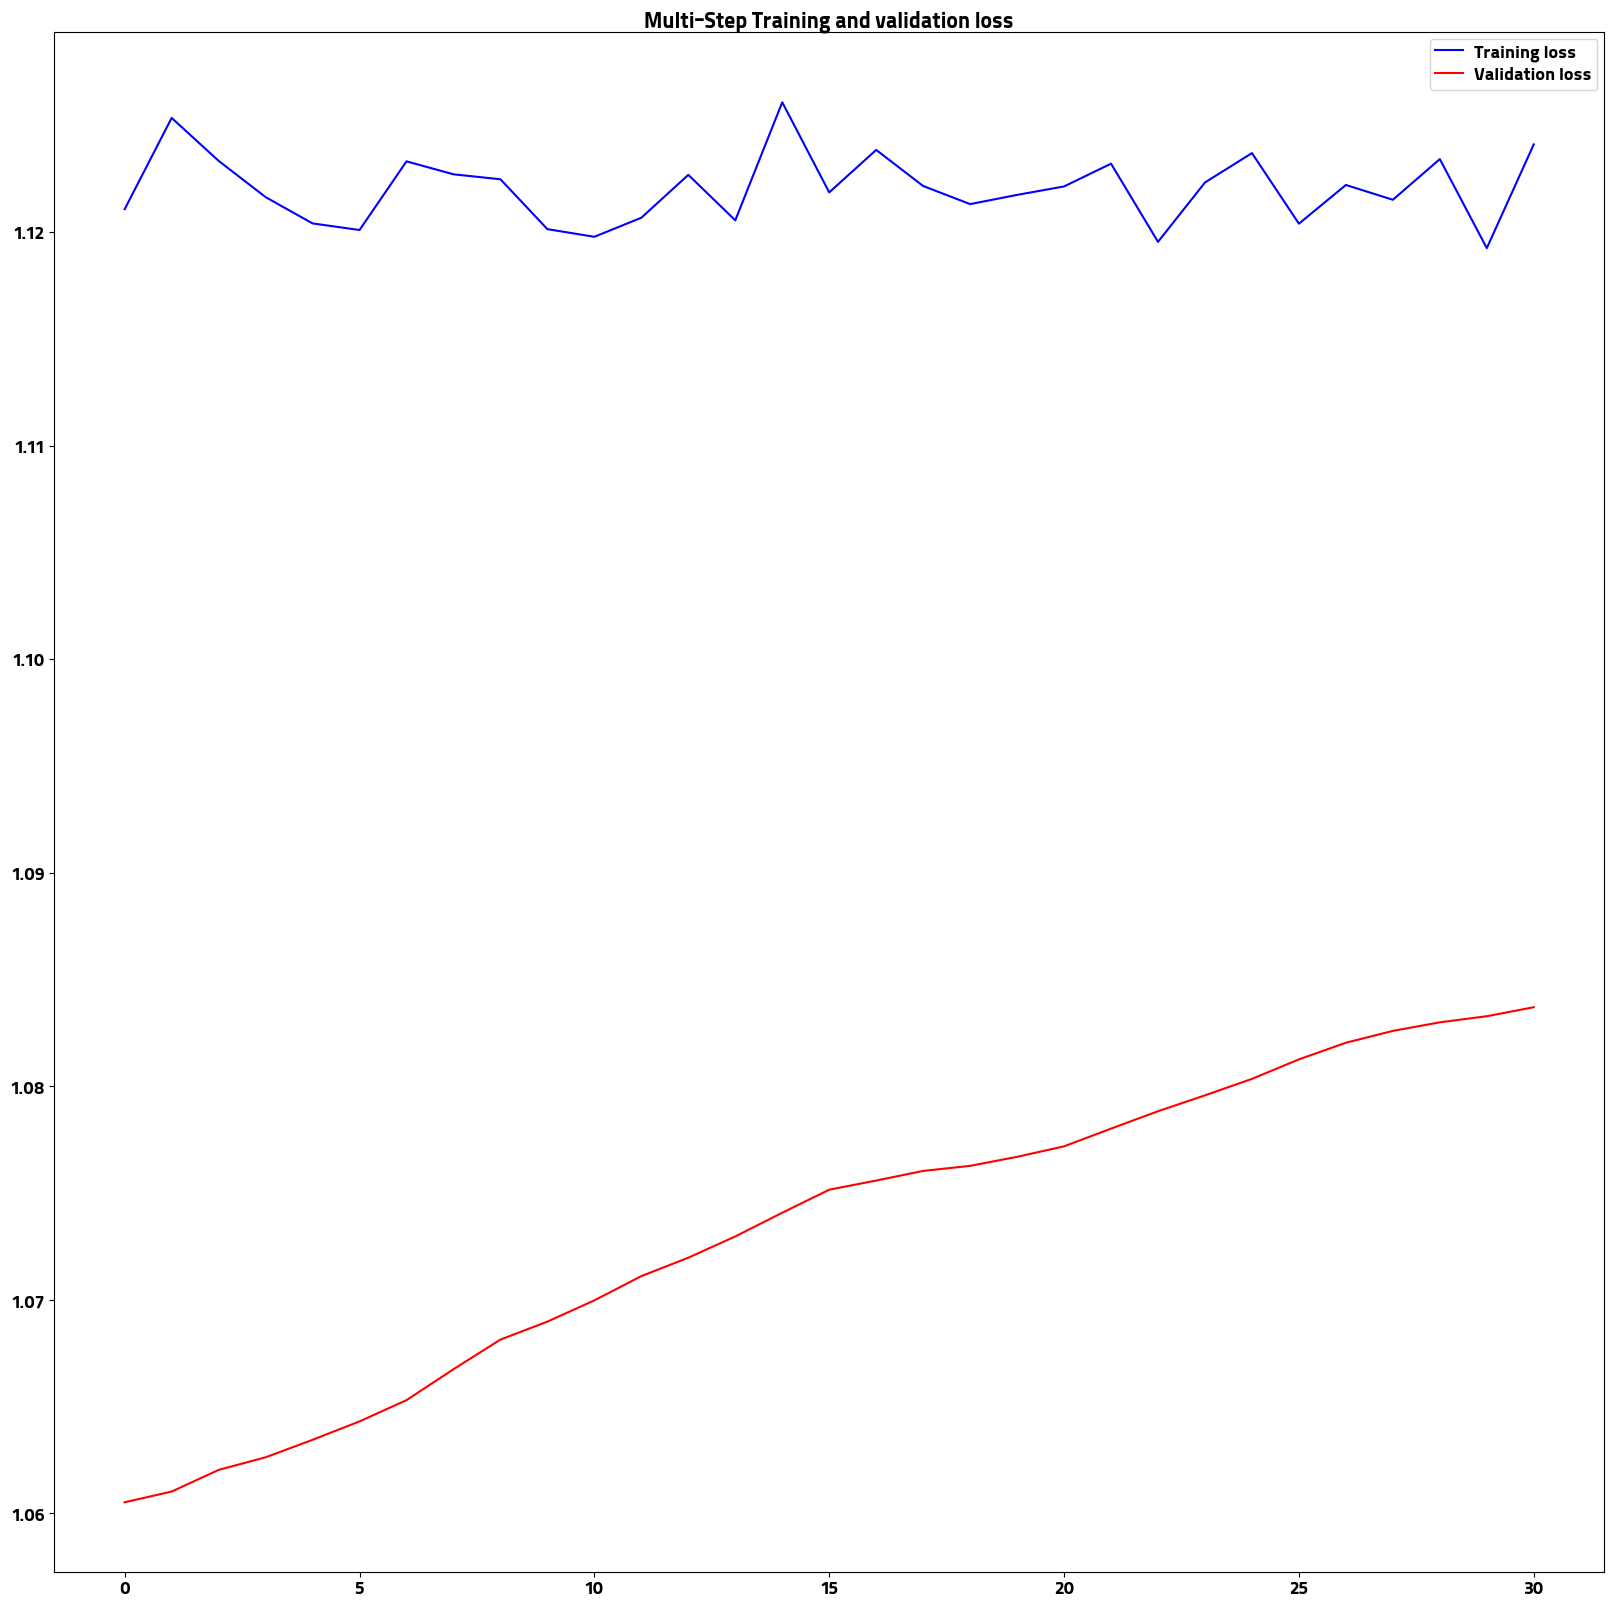

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
n_future_months = 12  # 예측할 미래 개월 수 (2023년 예측)
last_window = np.array(dataset[-past_history:]).reshape(1, -1, dataset.shape[1])

future_predictions = []

for _ in range(n_future_months):
    prediction = multi_step_model.predict(last_window)
    future_predictions.append(prediction[0, 0])

    new_row = np.zeros_like(last_window[0:-1])
    new_row[:-1] = last_window[0, -1, 1:]
    new_row[-1] = prediction
    last_window = np.concatenate((last_window[:, 1:, :], new_row.reshape(1, 1, -1)), axis=1)

future_predictions = np.array(future_predictions)
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=n_future_months, freq='M')


1/1 [==============================] - 0s 271ms/step


ValueError: could not broadcast input array from shape (10,) into shape (0,36,11)

1/1 [==============================] - 1s 556ms/step


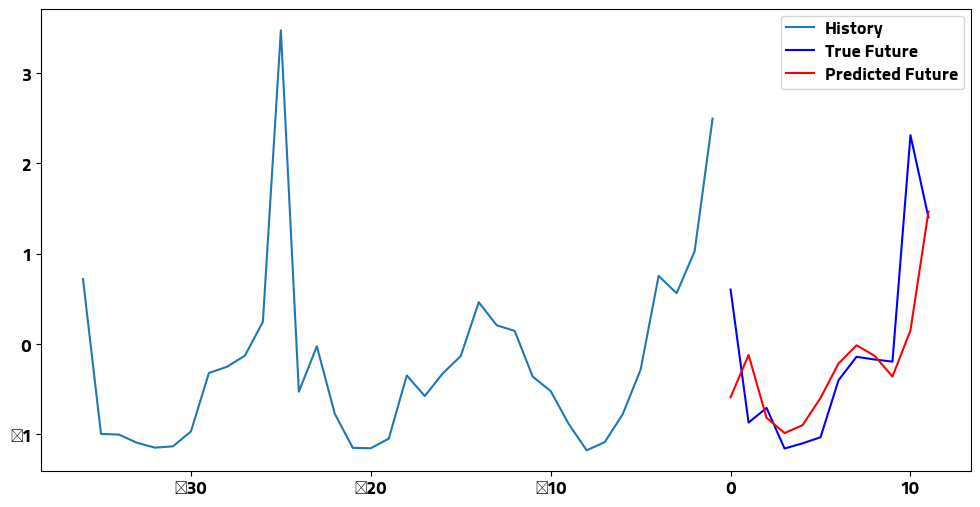

1/1 [==============================] - 0s 23ms/step


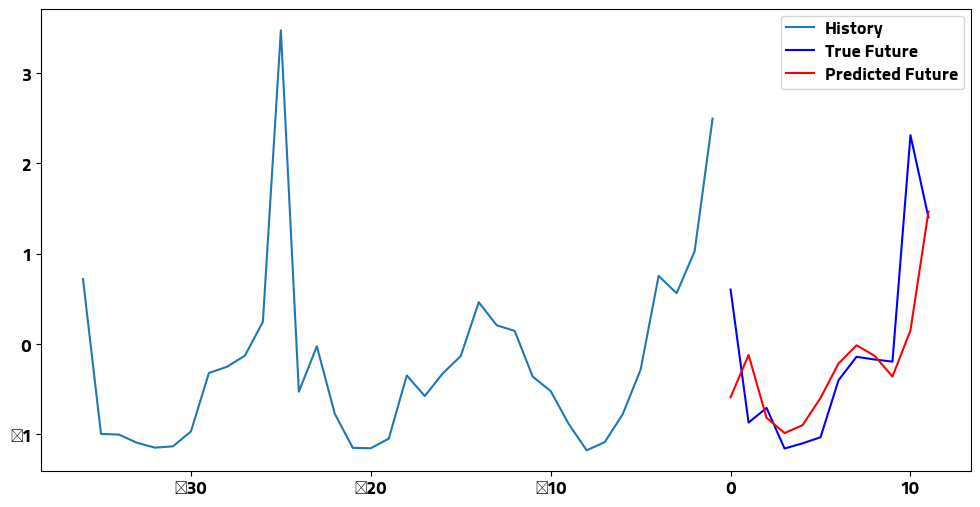

1/1 [==============================] - 0s 24ms/step


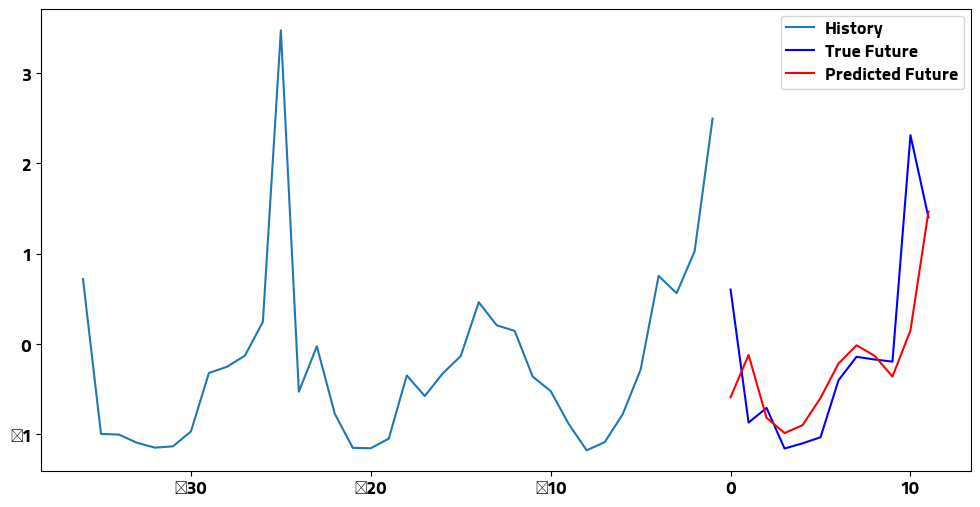

In [ ]:
for x, y in valid_data.take(3):
  mplot(x[0], y[0], multi_step_model.predict(x)[0], future_dates, future_predictions)